# Hybrid Optimization for PINNs

In this notebook we study **optimization strategies for Physics-Informed Neural Networks (PINNs)**,
focusing on a one-dimensional Poisson problem.

We compare:
- Adam (adaptive first-order optimization),
- L-BFGS (quasi-Newton method),
- a **hybrid Adam → L-BFGS strategy with automatic switching**.

Key questions:
- Why does Adam often work well in early PINN training?
- Why does L-BFGS often outperform Adam near convergence?
- How can we combine both methods automatically?

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

torch.manual_seed(0)
np.random.seed(0)

## 2. Model problem: 1D Poisson equation

We consider the Poisson problem on $\Omega = (0,1)$:
$$-u''(x) = f(x), \qquad u(0)=u(1)=0,$$
with a forcing term containing multiple frequencies.

This produces a solution with mixed low- and high-frequency components.
Neural networks exhibit **spectral bias**: they learn low frequencies easily but struggle
with high-frequency modes. This is an ideal testbed for comparing optimizer strategies.

In [ ]:
def u_exact_np(x):
    """Exact solution: superposition of three sine modes."""
    return (
        np.sin(np.pi * x)
        + 0.3 * np.sin(4 * np.pi * x)
        + 0.1 * np.sin(9 * np.pi * x)
    )

def f_force(x):
    """Forcing term: RHS of -u''(x) = f(x)."""
    return (
        -(np.pi**2) * torch.sin(np.pi * x)
        - 0.3 * (4*np.pi)**2 * torch.sin(4*np.pi * x)

        - 0.1 * (9*np.pi)**2 * torch.sin(9*np.pi * x)    )

## 3. Training points and boundary conditions

We enforce boundary conditions **strongly** by embedding them into the network
architecture. This approach:
- Guarantees BC satisfaction exactly (not approximately)
- Eliminates penalty hyperparameters that require tuning
- Reduces the effective parameter space and improves conditioning

In [ ]:
# Extract boundary values
u0 = float(u_exact_np(0.0))
u1 = float(u_exact_np(1.0))

# Training mesh
Ntrain = 300
x_np = np.linspace(0.0, 1.0, Ntrain)
x = torch.tensor(x_np, dtype=torch.float32).unsqueeze(1)


# Reference solution and forcing functionf_rhs = f_force(x)
u_exact = torch.tensor(u_exact_np(x_np), dtype=torch.float32).unsqueeze(1)

## 4. PINN with embedded boundary conditions

We parameterize the solution as:
$$u_\theta(x) = (1-x)u(0) + x u(1) + x(1-x)\,n_\theta(x),$$
where $n_\theta(x)$ is a neural network. The $x(1-x)$ factor ensures that:
- At $x=0$: $u_\theta(0) = u(0)$ (automatically)
- At $x=1$: $u_\theta(1) = u(1)$ (automatically)
- The network only needs to learn the interior behavior, not boundary satisfaction

In [ ]:
class PINN(nn.Module):
    """PINN with boundary conditions embedded in the network."""
    
    def __init__(self, width=128):
        super().__init__()
        # Neural network for the interior part n(x)
        self.net = nn.Sequential(
            nn.Linear(1, width), nn.Tanh(),
            nn.Linear(width, width), nn.Tanh(),
            nn.Linear(width, 1)
        )


    def forward(self, x):        return (1 - x) * u0 + x * u1 + x * (1 - x) * n

        n = self.net(x)        # u(x) = (1-x)*u0 + x*u1 + x(1-x)*n(x) satisfies BCs exactly

## 5. Computing the PDE residual

The Poisson equation involves second derivatives, which we compute
using automatic differentiation.

In [ ]:
def pinn_second_derivative(model, x):
    """Compute d²u/dx² via automatic differentiation (2nd order)."""
    xg = x.clone().detach().requires_grad_(True)
    u = model(xg)
    # First derivative
    du = torch.autograd.grad(u, xg, torch.ones_like(u), create_graph=True)[0]
    # Second derivative
    d2u = torch.autograd.grad(du, xg, torch.ones_like(du), create_graph=True)[0]

    return d2uloss_fn = nn.MSELoss()


## 6. Utility functions

We use helper routines to:
- clone identical initializations,
- evaluate PDE loss and solution error.

In [ ]:
def clone_params_from(model_source, model_target):
    """Copy parameters from source to target model for fair comparison."""
    with torch.no_grad():
        for p_src, p_tgt in zip(model_source.parameters(), model_target.parameters()):
            p_tgt.copy_(p_src)

def compute_loss_and_error(model, x, f_rhs, u_exact):
    """Evaluate PDE residual loss and solution error norm."""
    uxx = pinn_second_derivative(model, x)
    loss = loss_fn(uxx, f_rhs).item()  # PDE residual

    err = torch.norm(model(x) - u_exact).item()  # Solution error    return loss, err

## 7. Optimizers: why combine Adam and L-BFGS?

### Adam (first-order adaptive method)
- Maintains per-parameter adaptive learning rates via momentum and second moments
- Inherently robust to poor scaling and initialization
- Excellent in early training when gradients may be unreliable
- **Limitation**: Adaptive rates often decay to near-zero values, causing stagnation near convergence

### L-BFGS (quasi-Newton method)
- Builds a low-rank approximation of the inverse Hessian from curvature history
- Achieves superlinear convergence near a minimizer
- Very effective for final accuracy improvements
- **Limitation**: Requires good initialization; poor starting points can lead to failures

### Hybrid strategy
The key insight: combine complementary strengths:
- **Adam phase** (exploration): Robust initialization and coarse convergence to a good region
- **L-BFGS phase** (refinement): Fast superlinear convergence to high accuracy

In [ ]:
def train_adam(model, x, f_rhs, u_exact, iters=2000, lr=1e-3):
    """Train PINN with Adam optimizer."""
    opt = optim.Adam(model.parameters(), lr=lr)
    losses, errs = [], []

    for k in range(iters):
        opt.zero_grad()
        uxx = pinn_second_derivative(model, x)
        loss = loss_fn(uxx, f_rhs)  # Minimize PDE residual
        loss.backward()
        opt.step()

        L, E = compute_loss_and_error(model, x, f_rhs, u_exact)
        losses.append(L)
        errs.append(E)

        if k % 200 == 0:
            print(f"[Adam] iter {k:4d} | loss={L:.3e} | err={E:.3e}")

    return np.array(losses), np.array(errs)

## 9. Training with L-BFGS

PyTorch's L-BFGS requires a *closure* because it may evaluate
the loss and gradient multiple times per step.

In [ ]:
def train_lbfgs(model, x, f_rhs, u_exact,
                max_iters=500,
                history_size=50,
                tol_grad=1e-12,
                tol_change=1e-12):
    """Train PINN with L-BFGS optimizer (quasi-Newton method)."""
    losses, errs = [], []

    opt = optim.LBFGS(
        model.parameters(),
        max_iter=1,
        history_size=history_size,
        line_search_fn="strong_wolfe",
        tolerance_grad=tol_grad,
        tolerance_change=tol_change
    )

    for k in range(max_iters):
        # L-BFGS requires a closure for re-evaluation
        def closure():
            opt.zero_grad()
            uxx = pinn_second_derivative(model, x)
            loss = loss_fn(uxx, f_rhs)
            loss.backward()
            return loss

        opt.step(closure)

        L, E = compute_loss_and_error(model, x, f_rhs, u_exact)
        losses.append(L)
        errs.append(E)

        if k % 50 == 0:
            print(f"[LBFGS] iter {k:4d} | loss={L:.3e} | err={E:.3e}")

    return np.array(losses), np.array(errs)

## 10. Automatic Adam → L-BFGS switching

We monitor the **gradient norm** $\|\nabla L\|_2$ during Adam training.
When its decrease stagnates over a sliding window, we switch automatically to L-BFGS.

**Switching criterion**: Compare mean gradient norm over recent iterations versus earlier iterations.
If the ratio exceeds a threshold (e.g., 0.995), convergence has plateaued and it's time to switch.

This provides a principled, data-driven transition criterion that requires no manual tuning
of iteration counts or wall-clock time.

In [ ]:
def train_adam_then_lbfgs_automatic_switch(
        model,
        x, f_rhs, u_exact,
        adam_max_iters=8000,
        adam_min_iters=500,
        lbfgs_iters=1000,
        lr_adam=1e-4,
        window=200,
        plateau_tol=0.995,
        history_size=50,
        tol_grad=1e-12,
        tol_change=1e-12):
    """Train with Adam first, then automatically switch to L-BFGS on convergence plateau."""
    losses, errs, grad_norms = [], [], []

    opt_adam = optim.Adam(model.parameters(), lr=lr_adam)

    def grad_norm():
        """Compute L2 norm of gradients."""
        return sum(p.grad.norm().item()**2 for p in model.parameters()
                   if p.grad is not None)**0.5

    # ----- Adam stage: early exploration -----
    for k in range(adam_max_iters):
        opt_adam.zero_grad()
        uxx = pinn_second_derivative(model, x)
        loss = loss_fn(uxx, f_rhs)
        loss.backward()
        opt_adam.step()

        L, E = compute_loss_and_error(model, x, f_rhs, u_exact)
        gnorm = grad_norm()

        losses.append(L)
        errs.append(E)
        grad_norms.append(gnorm)

        # Check for convergence plateau using sliding window
        if k > adam_min_iters + window:
            r = np.mean(grad_norms[-window:]) / np.mean(grad_norms[-2*window:-window])
            if r > plateau_tol:  # Stagnation detected
                print(f">>> Switching to L-BFGS at iter {k}")
                break

    # ----- L-BFGS stage: final refinement -----
    opt_lbfgs = optim.LBFGS(
        model.parameters(),
        max_iter=1,
        history_size=history_size,
        line_search_fn="strong_wolfe",
        tolerance_grad=tol_grad,
        tolerance_change=tol_change
    )

    for k in range(lbfgs_iters):
        def closure():
            opt_lbfgs.zero_grad()
            uxx = pinn_second_derivative(model, x)
            loss = loss_fn(uxx, f_rhs)
            loss.backward()
            return loss

        opt_lbfgs.step(closure)

        L, E = compute_loss_and_error(model, x, f_rhs, u_exact)
        losses.append(L)
        errs.append(E)

    return np.array(losses), np.array(errs), np.array(grad_norms)

## 11. Comparison with identical initialization

In [ ]:
# Initialize three identical PINNs
model_adam = PINN()
model_lbfgs = PINN()
model_hybrid = PINN()

# Clone parameters for fair comparison
clone_params_from(model_adam, model_lbfgs)
clone_params_from(model_adam, model_hybrid)

# Train each model with different strategies
loss_adam, err_adam = train_adam(model_adam, x, f_rhs, u_exact, iters=5000, lr=5e-4)
loss_lbfgs, err_lbfgs = train_lbfgs(model_lbfgs, x, f_rhs, u_exact, max_iters=5000)
loss_hybrid, err_hybrid, _ = train_adam_then_lbfgs_automatic_switch(
    model_hybrid, x, f_rhs, u_exact,
    adam_max_iters=8000,
    adam_min_iters=500,

    lbfgs_iters=1500,)
    lr_adam=5e-4

[Adam] iter    0 | loss=4.342e+03 | err=1.259e+01
[Adam] iter  200 | loss=3.716e+03 | err=4.541e+00
[Adam] iter  400 | loss=4.712e+02 | err=2.022e+00
[Adam] iter  600 | loss=1.402e+01 | err=3.455e-01
[Adam] iter  800 | loss=5.165e+00 | err=2.464e-01
[Adam] iter 1000 | loss=3.472e+00 | err=1.797e-01
[Adam] iter 1200 | loss=2.656e+00 | err=1.542e-01
[Adam] iter 1400 | loss=2.135e+00 | err=1.348e-01
[Adam] iter 1600 | loss=1.826e+00 | err=1.224e-01
[Adam] iter 1800 | loss=1.589e+00 | err=1.146e-01
[Adam] iter 2000 | loss=1.375e+00 | err=1.068e-01
[Adam] iter 2200 | loss=1.209e+00 | err=9.894e-02
[Adam] iter 2400 | loss=1.058e+00 | err=9.146e-02
[Adam] iter 2600 | loss=7.619e-01 | err=5.988e-02
[Adam] iter 2800 | loss=4.143e-01 | err=2.618e-02
[Adam] iter 3000 | loss=1.943e-01 | err=9.824e-03
[Adam] iter 3200 | loss=1.017e-01 | err=4.038e-03
[Adam] iter 3400 | loss=6.051e-02 | err=2.322e-03
[Adam] iter 3600 | loss=6.902e-02 | err=5.648e-03
[Adam] iter 3800 | loss=2.976e-02 | err=6.937e-04


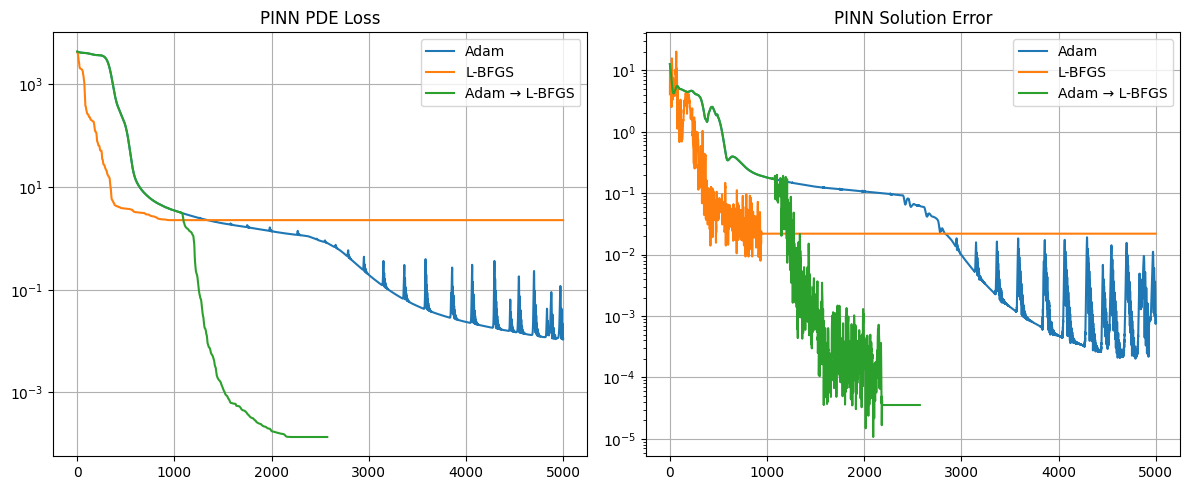

In [ ]:
# Compare convergence curves
plt.figure(figsize=(12,5))

# PDE residual loss
plt.subplot(1,2,1)
plt.semilogy(loss_adam, label="Adam")
plt.semilogy(loss_lbfgs, label="L-BFGS")
plt.semilogy(loss_hybrid, label="Adam → L-BFGS")
plt.title("PINN PDE Loss")
plt.legend(); plt.grid(True)

# Solution error
plt.subplot(1,2,2)
plt.semilogy(err_adam, label="Adam")
plt.semilogy(err_lbfgs, label="L-BFGS")
plt.semilogy(err_hybrid, label="Adam → L-BFGS")
plt.title("PINN Solution Error")
plt.legend(); plt.grid(True)

plt.show()
plt.tight_layout()

## Final takeaways

- **Adam** is excellent for **early-stage PINN training**: robust to poor initialization and effective at escaping flat regions.
- **L-BFGS** is extremely effective for **final accuracy**: achieves superlinear convergence once near a minimizer.
- **Hybrid strategy** combines the best of both worlds:
  - Avoids Adam's stagnation plateau
  - Leverages L-BFGS's superior local convergence

  - Requires no prior knowledge of problem structure

- **Automatic switching** uses gradient norm stagnation as a signal, eliminating manual iteration count guessing.- This approach scales well to high-dimensional PINNs and other PDE-constrained optimization problems.